In [13]:
# Imports
import pandas as pd
import numpy as np
import datetime
from datetime import time as dtime
from datetime import timedelta
from datetime import date
import matplotlib as plt
from itertools import product
import openpyxl

# pd.set_option('display.max_rows', None)     # show all rows
# pd.set_option('display.max_columns', None)  # show all columns
# pd.set_option('display.width', None)        # don't wrap lines
# pd.set_option('display.max_colwidth', None)



# importing historical data for backtest
def get1minBars(csvName):
    
    priceData1minBars_df = pd.read_csv(csvName, usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
    
    # Parse datetime column and divide in 2 columns
    # SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
    priceData1minBars_df.rename(columns={
        'date': 'datetime'
    }, inplace=True)
    
    priceData1minBars_df['datetime'] = pd.to_datetime(priceData1minBars_df['datetime'])
    
    priceData1minBars_df['Date'] = priceData1minBars_df['datetime'].dt.date
    priceData1minBars_df['Time'] = priceData1minBars_df['datetime'].dt.time
    
    # sorting the data by the time column to make sure it is consistent
    priceData1minBars_df.sort_values('datetime', inplace=True)
    
    # Drop original 'date' column
    # SPY_Data.drop(columns=['date'], inplace=True)
    
    # Filter for regular trading hours using datetime column
    # priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time >= pd.to_datetime("09:30").time()]
    # priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time <= pd.to_datetime("16:00").time()]
    
    # Making sure the order of the columns stays the same 
    priceData1minBars_df = priceData1minBars_df[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
    
    return priceData1minBars_df
    
    
NQ_Data = get1minBars('NQ_1min_master.csv')
NQ_Data = NQ_Data.drop_duplicates()
# QQQ_Data = QQQ_Data[472980:483000]
# ES_Data = ES_Data[:int(len(ES_Data)/2)]

NQ_Data_full = NQ_Data.copy()

# -----------------------------------
from datetime import date

start = date(2024, 11, 1)
end   = date(2024, 11, 30)

ES_Data_Nov2024 = NQ_Data[
    (NQ_Data['Date'] >= start) &
    (NQ_Data['Date'] <= end)
].copy()
# -----------------------------------

date_str = '2025-04-30'
day = pd.to_datetime(date_str).date()
NQ_Data = NQ_Data_full[NQ_Data_full['Date'] == day].copy()





def resample_to_5min(df):
    df = df.copy()

    # Ensure datetime index
    df['datetime_index'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
    df.set_index('datetime_index', inplace=True)

    # Resample to 5-minute bars
    df_5m = (
        df.resample(
            '5T',
            label='right',      # bar timestamp at end of window
            closed='right'      # include right edge
        )
        .agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        })
        .dropna()
    )

    # Recreate Date / Time columns
    df_5m['Date'] = df_5m.index.date
    df_5m['Time'] = df_5m.index.time

    # Reorder columns
    df_5m = df_5m[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]

    return df_5m


NQ_5min = resample_to_5min(NQ_Data_full)



NQ_Data
# ES_Data_Nov2024



import pandas as pd
import numpy as np

def add_session_id(df: pd.DataFrame, start_hour: int = 22) -> pd.DataFrame:
    """
    Adds:
      - session_date: the trading session label date (rolls at start_hour)
      - session_ID  : 1..N integer increasing over time

    Assumes df has either:
      - 'datetime' column, OR
      - 'Date' and 'Time' columns (Date as date-like, Time as time-like or string)
    """
    out = df.copy()

    # Ensure datetime exists
    if "datetime" not in out.columns:
        out["datetime"] = pd.to_datetime(
            out["Date"].astype(str) + " " + out["Time"].astype(str),
            errors="coerce"
        )

    out = out.sort_values("datetime").reset_index(drop=True)

    # Base calendar date from datetime
    base_date = out["datetime"].dt.date

    # Roll session date at start_hour (23:00)
    roll = out["datetime"].dt.hour >= start_hour
    out["session_date"] = pd.to_datetime(base_date) + pd.to_timedelta(roll.astype(int), unit="D")
    out["session_date"] = out["session_date"].dt.date  # keep as date (optional)

    # Monotonic integer id (1..N) in time order
    # Use factorize on the ordered unique session_date sequence
    out["session_ID"] = pd.factorize(out["session_date"], sort=True)[0] + 1
    
    out = out.drop(columns=["session_date"])
    
    return out

# usage
NQ_5min = add_session_id(NQ_5min, start_hour=22)
NQ_5min




import numpy as np
import pandas as pd
from datetime import time as dtime

# ------- Minimal ADX helper (used only if DIp14/60, DIn14/60, ADX14/60 not already present) -------
def _compute_adx_block(df, n=14, per_session=True):
    out = df.copy()
    if per_session:
        prev_high = out.groupby('Date')['high'].shift(1)
        prev_low  = out.groupby('Date')['low'].shift(1)
        prev_close= out.groupby('Date')['close'].shift(1)
    else:
        prev_high = out['high'].shift(1)
        prev_low  = out['low'].shift(1)
        prev_close= out['close'].shift(1)

    up_move   = out['high'] - prev_high
    down_move = prev_low - out['low']
    plus_dm   = np.where((up_move > 0) & (up_move > down_move), up_move, 0.0)
    minus_dm  = np.where((down_move > 0) & (down_move > up_move), down_move, 0.0)
    plus_dm   = pd.Series(plus_dm, index=out.index)
    minus_dm  = pd.Series(minus_dm, index=out.index)

    tr1 = (out['high'] - out['low']).abs()
    tr2 = (out['high'] - prev_close).abs()
    tr3 = (out['low'] - prev_close).abs()
    tr = np.maximum(tr1, np.maximum(tr2, tr3)).fillna(tr1)

    def _smooth(s, n_):
        return s.ewm(alpha=1/n_, adjust=False).mean()

    if per_session:
        tr_n      = tr.groupby(out['Date']).transform(lambda s: _smooth(s, n))
        plus_dm_n = plus_dm.groupby(out['Date']).transform(lambda s: _smooth(s, n))
        minus_dm_n= minus_dm.groupby(out['Date']).transform(lambda s: _smooth(s, n))
    else:
        tr_n      = _smooth(tr, n)
        plus_dm_n = _smooth(plus_dm, n)
        minus_dm_n= _smooth(minus_dm, n)

    eps = 1e-12
    dip = 100.0 * (plus_dm_n / (tr_n + eps))
    din = 100.0 * (minus_dm_n / (tr_n + eps))
    dx  = 100.0 * (np.abs(dip - din) / (dip + din + eps))
    adx = (dx.groupby(out['Date']).transform(lambda s: _smooth(s, n))
           if per_session else _smooth(dx, n))

    return dip, din, adx

# ------- ATR helper (Wilder), per session if desired -------
def _wilder_atr(df, n, per_session=True):
    if per_session:
        prev_close = df.groupby('Date')['close'].shift(1)
    else:
        prev_close = df['close'].shift(1)
    tr1 = (df['high'] - df['low']).abs()
    tr2 = (df['high'] - prev_close).abs()
    tr3 = (df['low'] - df['close'].shift(1)).abs()
    tr = np.maximum(tr1, np.maximum(tr2, tr3)).fillna(tr1)
    smooth = tr.groupby(df['Date']).transform(lambda s: s.ewm(alpha=1/n, adjust=False).mean()) \
             if per_session else tr.ewm(alpha=1/n, adjust=False).mean()
    return smooth

# ------- Time-in-window helper (handles str, datetime.time, or Timestamp) -------
def _in_windows(t, windows):
    if isinstance(t, pd.Timestamp):
        tt = t.time()
    elif isinstance(t, str):
        # parse fast HH:MM:SS or HH:MM
        parts = [int(x) for x in t.split(':')]
        while len(parts) < 3: parts.append(0)
        tt = dtime(parts[0], parts[1], parts[2])
    else:
        tt = t  # assume datetime.time
    for start, end in windows:
        if start <= tt <= end:
            return True
    return False

def classify_market_regime(
    df,
    atr_per_session=False,
    params=None,
    time_windows=None,
):
    """
    Adds regime labels & filters.

    Inputs:
      df: DataFrame with columns ['Date','Time','open','high','low','close','volume']
          and ideally DIp14/DIn14/ADX14 & DIp60/DIn60/ADX60 (will compute if missing).
      atr_per_session: reset ATR/ADX within each Date session if True.

    params (defaults below):
      {
        'adx14_chop': 20,
        'adx60_trend': 18,
        'vol_ratio_expand': 1.20,   # ATR5/ATR60 >= expand → expansion
        'vol_ratio_chop':   0.90,   # ATR5/ATR60 <= chop   → compression
        'adx14_rise_lookback': 5,   # rising ADX14 over N bars
        'min_range_mult_exhaust': 2.0,  # optional: mark exhaustion bars (not used to filter, but computed)
      }

    time_windows:
      list of (start_time, end_time) tuples; times as datetime.time.
      Defaults to RTH focus: [(09:35, 11:30), (13:30, 15:30)] Eastern-like.
    """
    if params is None:
        params = dict(
            adx14_chop=20,
            adx60_trend=18,
            vol_ratio_expand=1.20,
            vol_ratio_chop=0.90,
            adx14_rise_lookback=5,
            min_range_mult_exhaust=2.0,
        )

    if time_windows is None:
        time_windows = [(dtime(9,35), dtime(11,30)), (dtime(13,30), dtime(15,30))]

    out = df.copy()
    out[['open','high','low','close']] = out[['open','high','low','close']].astype(float)

    # --- Ensure ADX14/60 (+DI/-DI) exist (compute if missing) ---
    need_14 = not {'DIp14','DIn14','ADX14'}.issubset(out.columns)
    need_60 = not {'DIp60','DIn60','ADX60'}.issubset(out.columns)
    if need_14:
        dip14, din14, adx14 = _compute_adx_block(out, n=14, per_session=atr_per_session)
        out['DIp14'], out['DIn14'], out['ADX14'] = dip14, din14, adx14
    if need_60:
        dip60, din60, adx60 = _compute_adx_block(out, n=60, per_session=atr_per_session)
        out['DIp60'], out['DIn60'], out['ADX60'] = dip60, din60, adx60

    # --- ATRs & Volatility ratio ---
    out['ATR5']  = _wilder_atr(out, 5,  per_session=atr_per_session)
    out['ATR60'] = _wilder_atr(out, 60, per_session=atr_per_session)
    eps = 1e-12
    out['vol_ratio'] = (out['ATR5'] / (out['ATR60'] + eps)).clip(lower=0)

    # --- ADX14 rising metric ---
    look = int(params['adx14_rise_lookback'])
    out['ADX14_rise'] = out['ADX14'] - out['ADX14'].shift(look)

    # --- Optional: exhaustion bar marker (current range vs 20-bar avg) ---
    out['range'] = (out['high'] - out['low']).abs()
    out['avg_range20'] = out['range'].rolling(20).mean()
    out['is_exhaustion'] = out['range'] > (params['min_range_mult_exhaust'] * out['avg_range20'])

    # --- Regime rules ---
    chop = (out['ADX14'] <= params['adx14_chop']) & (out['vol_ratio'] <= params['vol_ratio_chop'])
    trend_up   = (out['ADX60'] >= params['adx60_trend']) & (out['DIp60'] > out['DIn60'])
    trend_down = (out['ADX60'] >= params['adx60_trend']) & (out['DIp60'] < out['DIn60'])
    expansion  = (out['vol_ratio'] >= params['vol_ratio_expand']) & (out['ADX14_rise'] > 0)

    # Priority: expansion > trend > chop > neutral
    regime = np.where(expansion, 'expansion',
              np.where(trend_up, 'trend_up',
              np.where(trend_down, 'trend_down',
              np.where(chop, 'chop', 'neutral'))))
    out['regime'] = regime

    # Side bias
    out['side_bias'] = np.where(out['regime']=='trend_up', 'long',
                         np.where(out['regime']=='trend_down', 'short', 'neutral'))

    # Time-of-day tradability
    out['in_window'] = [ _in_windows(t, time_windows) for t in out['Time'] ]
    # Tradable regimes (you can tweak)
    tradable_regimes = {'expansion', 'trend_up', 'trend_down'}
    # out['tradable'] = out['in_window'] & out['regime'].isin(tradable_regimes)
    out['tradable'] = out['regime'].isin(tradable_regimes)
    
    

    return out

regime_df = classify_market_regime(NQ_5min)


sig_cols = ['regime','side_bias','tradable','in_window',
            'vol_ratio','ADX14','ADX60','DIp60','DIn60','DIp14','DIn14',
            'ADX14_rise','ATR5','ATR60']

regime_df[sig_cols] = regime_df.groupby('Date')[sig_cols].shift(1)
regime_df

,Date,Time,open,high,low,close,volume,datetime,session_ID,DIp14,...,ATR60,vol_ratio,ADX14_rise,range,avg_range20,is_exhaustion,regime,side_bias,in_window,tradable
0,2023-11-01,22:00:00,14761.25,14763.50,14760.00,14760.00,175,2023-11-01 22:00:00,1,NaN,...,NaN,NaN,NaN,3.50,NaN,False,NaN,NaN,NaN,NaN
1,2023-11-01,22:05:00,14760.50,14764.00,14760.50,14763.00,335,2023-11-01 22:05:00,1,0.000000,...,3.500000,1.000000,NaN,3.50,NaN,False,neutral,neutral,False,False
2,2023-11-01,22:10:00,14762.50,14769.75,14762.50,14766.50,494,2023-11-01 22:10:00,1,1.010101,...,3.508333,1.026128,NaN,7.25,NaN,False,neutral,neutral,False,False
3,2023-11-01,22:15:00,14766.50,14773.25,14765.50,14771.25,409,2023-11-01 22:15:00,1,11.677852,...,3.570694,1.212649,NaN,7.75,NaN,False,neutral,neutral,False,False
4,2023-11-01,22:20:00,14771.75,14773.50,14764.50,14764.50,423,2023-11-01 22:20:00,1,16.217422,...,3.640350,1.377340,NaN,9.00,NaN,False,neutral,neutral,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141418,2025-10-31,20:40:00,25977.50,25986.00,25976.25,25980.50,685,2025-10-31 20:40:00,551,16.575295,...,26.890058,0.768425,-2.444153,9.75,26.9625,False,neutral,neutral,False,False
141419,2025-10-31,20:45:00,25980.25,25982.75,25974.00,25982.25,500,2025-10-31 20:45:00,551,16.332420,...,26.604391,0.694637,-2.261921,8.75,25.8875,False,neutral,neutral,False,False
141420,2025-10-31,20:50:00,25981.75,25987.25,25975.00,25985.00,673,2025-10-31 20:50:00,551,15.911948,...,26.306818,0.628518,-2.187788,12.25,25.5375,False,neutral,neutral,False,False
141421,2025-10-31,20:55:00,25985.50,25994.25,25982.00,25993.00,446,2025-10-31 20:55:00,551,16.689982,...,26.072537,0.601301,-2.418340,12.25,25.3125,False,neutral,neutral,False,False


In [15]:
import numpy as np
import pandas as pd
from datetime import time as dtime

# ----------------------------
# Helpers (NO df.copy() inside)
# ----------------------------

def _ensure_datetime(df: pd.DataFrame) -> pd.DataFrame:
    out = df
    if "datetime" not in out.columns:
        out["datetime"] = pd.to_datetime(
            out["Date"].astype(str) + " " + out["Time"].astype(str),
            errors="coerce"
        )
    return out

def _ewm_wilder_grouped(x: pd.Series, n: int, group: pd.Series) -> pd.Series:
    # Wilder smoothing is equivalent to EMA with alpha=1/n, adjust=False
    return x.groupby(group).transform(lambda s: s.ewm(alpha=1/n, adjust=False).mean())

def _true_range(high: pd.Series, low: pd.Series, prev_close: pd.Series) -> pd.Series:
    tr1 = (high - low).abs()
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = np.maximum(tr1, np.maximum(tr2, tr3))
    # If prev_close is NaN (first bar of session), fallback to tr1
    tr = pd.Series(tr, index=high.index).fillna(tr1)
    return tr

def _compute_di_adx_session_local(
    high: pd.Series,
    low: pd.Series,
    close: pd.Series,
    session_id: pd.Series,
    n: int = 14
):
    """
    Session-local DI+/DI-/ADX using Wilder smoothing within each session_ID.
    Returns dip, din, adx as Series aligned to input index.
    """
    prev_high  = high.groupby(session_id).shift(1)
    prev_low   = low.groupby(session_id).shift(1)
    prev_close = close.groupby(session_id).shift(1)

    up_move   = high - prev_high
    down_move = prev_low - low

    plus_dm  = pd.Series(np.where((up_move > 0) & (up_move > down_move), up_move, 0.0), index=high.index)
    minus_dm = pd.Series(np.where((down_move > 0) & (down_move > up_move), down_move, 0.0), index=high.index)

    tr = _true_range(high, low, prev_close)

    tr_n       = _ewm_wilder_grouped(tr, n, session_id)
    plus_dm_n  = _ewm_wilder_grouped(plus_dm, n, session_id)
    minus_dm_n = _ewm_wilder_grouped(minus_dm, n, session_id)

    eps = 1e-12
    dip = 100.0 * (plus_dm_n / (tr_n + eps))
    din = 100.0 * (minus_dm_n / (tr_n + eps))
    dx  = 100.0 * (np.abs(dip - din) / (dip + din + eps))
    adx = _ewm_wilder_grouped(dx, n, session_id)

    return dip, din, adx

def _atr_session_local(
    high: pd.Series,
    low: pd.Series,
    close: pd.Series,
    session_id: pd.Series,
    n: int = 14
) -> pd.Series:
    prev_close = close.groupby(session_id).shift(1)
    tr = _true_range(high, low, prev_close)
    return _ewm_wilder_grouped(tr, n, session_id)

def _rolling_percentile_rank_causal(x: pd.Series, window: int) -> pd.Series:
    """
    Causal rolling percentile rank of the LAST element in each window.
    Returns values in [0, 1]. Uses rolling apply (can be slower on huge datasets).
    """
    x = x.astype(float)

    def _pct(arr: np.ndarray) -> float:
        # percentile rank of last value within the window (inclusive)
        last = arr[-1]
        # rank = fraction <= last (ties included)
        return float(np.mean(arr <= last))

    return x.rolling(window=window, min_periods=max(10, window//10)).apply(_pct, raw=True)

def _robust_zscore_grouped(x: pd.Series, group: pd.Series, window: int) -> pd.Series:
    """
    Robust-ish zscore per session using rolling mean/std.
    (If you want true robust MAD zscore, we can do that too, but it’s slower.)
    """
    mu = x.groupby(group).transform(lambda s: s.rolling(window, min_periods=max(10, window//5)).mean())
    sd = x.groupby(group).transform(lambda s: s.rolling(window, min_periods=max(10, window//5)).std(ddof=0))
    return (x - mu) / sd.replace(0, np.nan)

def _label_session_phase(time_series: pd.Series) -> pd.Series:
    """
    Simple ES-like phase labeling; adjust to your preference.
    Assumes time_series is datetime.time or parseable strings.
    """
    def _to_time(t):
        if isinstance(t, dtime):
            return t
        if isinstance(t, pd.Timestamp):
            return t.time()
        if isinstance(t, str):
            parts = [int(p) for p in t.split(":")]
            while len(parts) < 3:
                parts.append(0)
            return dtime(parts[0], parts[1], parts[2])
        return t

    tt = time_series.map(_to_time)

    # Phases (you can tune)
    # Session starts 23:00; RTH open 09:30; close 16:00; session ends 22:00
    phases = []
    for t in tt:
        if t >= dtime(23,0) or t < dtime(2,0):
            phases.append("asia_early")
        elif t < dtime(9,30):
            phases.append("europe")
        elif t < dtime(10,30):
            phases.append("open_drive")
        elif t < dtime(14,0):
            phases.append("midday")
        elif t < dtime(16,0):
            phases.append("power_hour")
        else:
            phases.append("after_close")
    return pd.Series(phases, index=time_series.index)

def _in_windows_timecol(time_col: pd.Series, windows):
    def _to_time(t):
        if isinstance(t, pd.Timestamp):
            return t.time()
        if isinstance(t, str):
            parts = [int(x) for x in t.split(":")]
            while len(parts) < 3: parts.append(0)
            return dtime(parts[0], parts[1], parts[2])
        return t
    tt = time_col.map(_to_time)

    out = []
    for t in tt:
        ok = False
        for start, end in windows:
            if start <= t <= end:
                ok = True
                break
        out.append(ok)
    return pd.Series(out, index=time_col.index)

# ----------------------------
# Main Regime Function (v2)
# ----------------------------

def classify_market_regime_v2(
    df: pd.DataFrame,
    session_id_col: str = "session_ID",
    datetime_col: str = "datetime",
    time_col: str = "Time",
    # ADX/ATR lengths
    adx_fast: int = 14,
    adx_slow: int = 60,
    atr_fast: int = 5,
    atr_slow: int = 60,
    # Vol percentile lookback (bars)
    vol_pct_lookback: int = 2000,
    vol_expand_pct: float = 0.80,
    vol_compress_pct: float = 0.20,
    # Trend direction (HTF-ish EMA crossover on 1-min bars)
    ema_fast_minutes: int = 30,
    ema_slow_minutes: int = 60,
    require_slope_confirm: bool = True,
    slope_lookback: int = 15,
    # Shock detection
    shock_window: int = 120,
    shock_range_z: float = 3.0,
    shock_vol_z: float = 3.0,
    # Optional time windows for "in_window"
    time_windows=None,
) -> pd.DataFrame:
    """
    Returns df with added columns:
      - DIp{adx_fast}, DIn{adx_fast}, ADX{adx_fast}
      - DIp{adx_slow}, DIn{adx_slow}, ADX{adx_slow}
      - ATR{atr_fast}, ATR{atr_slow}
      - vol_ratio, vol_ratio_pct
      - ema_{ema_fast_minutes}m, ema_{ema_slow_minutes}m, ema_slope
      - vol_state, dir_state, regime (combined)
      - range_z, volume_z, is_shock
      - session_phase, in_window, tradable (optional)
    All session-local computations use session_ID (NOT Date).
    """

    out = df.copy()

    # Basic checks
    if session_id_col not in out.columns:
        raise ValueError(f"Missing '{session_id_col}'. Add session_ID first.")
    sid = out[session_id_col]

    # Ensure datetime and sort
    if datetime_col not in out.columns:
        out = _ensure_datetime(out)
        datetime_col = "datetime"

    out = out.sort_values(datetime_col).reset_index(drop=True)

    # Ensure numeric
    for c in ["open", "high", "low", "close", "volume"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")

    high = out["high"].astype(float)
    low  = out["low"].astype(float)
    close= out["close"].astype(float)
    vol  = out["volume"].astype(float)

    # --- DI/ADX session-local ---
    dip_f, din_f, adx_f = _compute_di_adx_session_local(high, low, close, sid, n=adx_fast)
    dip_s, din_s, adx_s = _compute_di_adx_session_local(high, low, close, sid, n=adx_slow)

    out[f"DIp{adx_fast}"] = dip_f
    out[f"DIn{adx_fast}"] = din_f
    out[f"ADX{adx_fast}"] = adx_f

    out[f"DIp{adx_slow}"] = dip_s
    out[f"DIn{adx_slow}"] = din_s
    out[f"ADX{adx_slow}"] = adx_s

    # --- ATR session-local + vol ratio ---
    out[f"ATR{atr_fast}"] = _atr_session_local(high, low, close, sid, n=atr_fast)
    out[f"ATR{atr_slow}"] = _atr_session_local(high, low, close, sid, n=atr_slow)

    eps = 1e-12
    out["vol_ratio"] = (out[f"ATR{atr_fast}"] / (out[f"ATR{atr_slow}"] + eps)).clip(lower=0)

    # --- Vol ratio percentile (causal, adaptive) ---
    # This is intentionally NOT session-local; it adapts across multiple sessions (but is still causal).
    out["vol_ratio_pct"] = _rolling_percentile_rank_causal(out["vol_ratio"], window=vol_pct_lookback)

    # --- Volatility state (multi-dimensional) ---
    out["vol_state"] = np.where(out["vol_ratio_pct"] >= vol_expand_pct, "expansion",
                        np.where(out["vol_ratio_pct"] <= vol_compress_pct, "compression", "normal"))

    # --- Trend direction state (EMA(30m) vs EMA(60m) on 1-minute bars) ---
    # Using EMA is smoother than SMA; minutes correspond to bars for 1-min data.
    ema_fast = out["close"].ewm(span=ema_fast_minutes, adjust=False, min_periods=ema_fast_minutes).mean()
    ema_slow = out["close"].ewm(span=ema_slow_minutes, adjust=False, min_periods=ema_slow_minutes).mean()

    out[f"ema_{ema_fast_minutes}m"] = ema_fast
    out[f"ema_{ema_slow_minutes}m"] = ema_slow
    
    # getting the 1 day, 3 day and 5 day EMA
    MIN_PER_DAY = 1380 # mins in a trading day
    out['ema_1d']  = out["close"].ewm(span=1 * MIN_PER_DAY, adjust=False,min_periods=1 * MIN_PER_DAY).mean()
    out['ema_3d']  = out["close"].ewm(span=3 * MIN_PER_DAY, adjust=False,min_periods=3 * MIN_PER_DAY).mean()
    out['ema_5d']  = out["close"].ewm(span=5 * MIN_PER_DAY, adjust=False,min_periods=5 * MIN_PER_DAY).mean()
    out['ema_30d']  = out["close"].ewm(span=30 * MIN_PER_DAY, adjust=False,min_periods=15 * MIN_PER_DAY).mean()

    # Slope confirmation (optional): slope of slow EMA over last N bars
    out["ema_slope"] = out[f"ema_{ema_slow_minutes}m"] - out[f"ema_{ema_slow_minutes}m"].shift(slope_lookback)

    if require_slope_confirm:
        up_cond   = (ema_fast > ema_slow) & (out["ema_slope"] > 0)
        down_cond = (ema_fast < ema_slow) & (out["ema_slope"] < 0)
    else:
        up_cond   = (ema_fast > ema_slow)
        down_cond = (ema_fast < ema_slow)

    out["dir_state"] = np.where(up_cond, "up", np.where(down_cond, "down", "flat"))

    # --- Shock detection (session-local zscores) ---
    out["range"] = (high - low).abs()
    out["range_z"] = _robust_zscore_grouped(out["range"], sid, window=shock_window)
    out["volume_z"] = _robust_zscore_grouped(vol, sid, window=shock_window)

    out["is_shock"] = (out["range_z"].abs() >= shock_range_z) | (out["volume_z"].abs() >= shock_vol_z)

    # --- Optional time-of-day buckets / windows ---
    out["session_phase"] = _label_session_phase(out[time_col]) if time_col in out.columns else "unknown"

    if time_windows is None:
        # Default: RTH focus windows
        time_windows = [(dtime(9,35), dtime(11,30)), (dtime(13,30), dtime(15,30))]
    if time_col in out.columns:
        out["in_window"] = _in_windows_timecol(out[time_col], time_windows)
    else:
        out["in_window"] = True

    # --- Combined regime label (if you want a single label too) ---
    out["regime"] = out["vol_state"].astype(str) + "_" + out["dir_state"].astype(str)

    # Tradable example (you can tighten/loosen)
    # For many ES systems: avoid compression_flat and avoid shock bars unless you explicitly trade them.
    out["tradable"] = (
        (out["vol_state"].isin(["normal", "expansion"])) &
        (out["dir_state"].isin(["up", "down"])) &
        (~out["is_shock"]) &
        (out["in_window"])
    )

    return out


def add_session_anchored_vwap(
    df: pd.DataFrame,
    session_id_col: str = "session_ID",
    price_mode: str = "typical"  # "typical" or "close"
) -> pd.DataFrame:
    """
    Adds session-anchored VWAP columns:
      - vwap_s : session VWAP
      - vwap_dist : close - vwap_s

    Requires:
      ['high','low','close','volume', session_ID]
    """

    out = df

    if price_mode == "typical":
        price = (out["high"] + out["low"] + out["close"]) / 3.0
    elif price_mode == "close":
        price = out["close"]
    else:
        raise ValueError("price_mode must be 'typical' or 'close'")

    pv = price * out["volume"]

    # Session-local cumulative sums
    cum_pv  = pv.groupby(out[session_id_col]).cumsum()
    cum_vol = out["volume"].groupby(out[session_id_col]).cumsum()

    out["vwap_s"] = cum_pv / cum_vol.replace(0, np.nan)

    # Distance to VWAP (points)
    out["vwap_dist"] = out["close"] - out["vwap_s"]

    return out


# ----------------------------
# Usage example (after you added session_ID)
# ----------------------------
regime_df = classify_market_regime_v2(NQ_5min)
regime_df = add_session_anchored_vwap(regime_df)

# Then, for causality in trading logic:
sig_cols = ["vol_state","dir_state","regime","tradable","in_window","session_phase",
            "vol_ratio","vol_ratio_pct","range_z","volume_z","is_shock",
            "ADX14","ADX60","DIp14","DIn14","DIp60","DIn60","ATR5","ATR60",
            "ema_30m","ema_60m","ema_slope", "vwap_s", "vwap_dist"]
regime_df[sig_cols] = regime_df.groupby("session_ID")[sig_cols].shift(1)
regime_df

,Date,Time,open,high,low,close,volume,datetime,session_ID,DIp14,...,range,range_z,volume_z,is_shock,session_phase,in_window,regime,tradable,vwap_s,vwap_dist
0,2023-11-01,22:00:00,14761.25,14763.50,14760.00,14760.00,175,2023-11-01 22:00:00,1,NaN,...,3.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-11-01,22:05:00,14760.50,14764.00,14760.50,14763.00,335,2023-11-01 22:05:00,1,0.000000,...,3.50,NaN,NaN,False,after_close,False,normal_flat,False,14761.166667,-1.166667
2,2023-11-01,22:10:00,14762.50,14769.75,14762.50,14766.50,494,2023-11-01 22:10:00,1,1.010101,...,7.25,NaN,NaN,False,after_close,False,normal_flat,False,14762.042484,0.957516
3,2023-11-01,22:15:00,14766.50,14773.25,14765.50,14771.25,409,2023-11-01 22:15:00,1,11.677852,...,7.75,NaN,NaN,False,after_close,False,normal_flat,False,14764.112716,2.387284
4,2023-11-01,22:20:00,14771.75,14773.50,14764.50,14764.50,423,2023-11-01 22:20:00,1,16.217422,...,9.00,NaN,NaN,False,after_close,False,normal_flat,False,14765.816820,5.433180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141418,2025-10-31,20:40:00,25977.50,25986.00,25976.25,25980.50,685,2025-10-31 20:40:00,551,16.575295,...,9.75,-1.096101,-1.127833,False,after_close,False,normal_down,False,26072.114804,-94.864804
141419,2025-10-31,20:45:00,25980.25,25982.75,25974.00,25982.25,500,2025-10-31 20:45:00,551,16.332419,...,8.75,-1.155942,-1.109253,False,after_close,False,normal_down,False,26072.008554,-91.508554
141420,2025-10-31,20:50:00,25981.75,25987.25,25975.00,25985.00,673,2025-10-31 20:50:00,551,15.911948,...,12.25,-1.223523,-1.165327,False,after_close,False,compression_down,False,26071.930094,-89.680094
141421,2025-10-31,20:55:00,25985.50,25994.25,25982.00,25993.00,446,2025-10-31 20:55:00,551,16.689982,...,12.25,-0.996045,-1.115983,False,after_close,False,compression_down,False,26071.827838,-86.827838


In [16]:
import numpy as np
import pandas as pd


def _forward_rolling_max(s: pd.Series, h: int) -> pd.Series:
    """
    For each t, returns max(s[t+1 : t+h]) (next h bars, excluding current).
    Must be called inside a group where index order is already correct.
    """
    x = pd.to_numeric(s, errors="coerce")
    x_shift = x.shift(-1)  # start at t+1
    rev = x_shift.iloc[::-1]
    rev_roll = rev.rolling(window=h, min_periods=h).max()
    return rev_roll.iloc[::-1]


def _forward_rolling_min(s: pd.Series, h: int) -> pd.Series:
    """
    For each t, returns min(s[t+1 : t+h]) (next h bars, excluding current).
    Must be called inside a group where index order is already correct.
    """
    x = pd.to_numeric(s, errors="coerce")
    x_shift = x.shift(-1)  # start at t+1
    rev = x_shift.iloc[::-1]
    rev_roll = rev.rolling(window=h, min_periods=h).min()
    return rev_roll.iloc[::-1]


def add_forward_stats(
    df: pd.DataFrame,
    horizons=(5, 15, 30, 60, 120),
    group_col: str = "session_ID",
    close_col: str = "close",
    high_col: str = "high",
    low_col: str = "low",
    atr_col = None,
    sort_col = "datetime",
    keep_intermediate: bool = True,
) -> pd.DataFrame:
    """
    Adds forward-looking stats per bar for each horizon in `horizons`, computed within `group_col`.

    Window convention:
      - forward windows use bars t+1 ... t+h (exclude current bar)
      - fwd_close_h is close[t+h]
    """
    out = df.copy()

    # ---- sanity checks ----
    if group_col not in out.columns:
        raise KeyError(f"Missing group column '{group_col}'. Add session_ID first or pass group_col accordingly.")

    for c in [close_col, high_col, low_col]:
        if c not in out.columns:
            raise KeyError(f"Missing required column: {c}")

    # ---- ensure numeric ----
    out[close_col] = pd.to_numeric(out[close_col], errors="coerce")
    out[high_col]  = pd.to_numeric(out[high_col],  errors="coerce")
    out[low_col]   = pd.to_numeric(out[low_col],   errors="coerce")

    if atr_col is not None:
        if atr_col not in out.columns:
            raise KeyError(f"atr_col='{atr_col}' not found in df.")
        out[atr_col] = pd.to_numeric(out[atr_col], errors="coerce").astype(float)

    # ---- sort within session to ensure forward logic is correct ----
    if sort_col is not None and sort_col in out.columns:
        out = out.sort_values([group_col, sort_col]).reset_index(drop=True)
    else:
        # fallback: assume current order is correct within each session
        out = out.reset_index(drop=True)

    g = out.groupby(group_col, sort=False)

    for h in map(int, horizons):
        # forward close
        out[f"fwd_close_{h}"] = g[close_col].shift(-h)

        # forward return in points
        out[f"fwd_ret_pts_{h}"] = out[f"fwd_close_{h}"] - out[close_col]

        # forward max/min over next h bars (transform avoids MultiIndex)
        out[f"fwd_max_high_{h}"] = g[high_col].transform(lambda s: _forward_rolling_max(s, h))
        out[f"fwd_min_low_{h}"]  = g[low_col].transform(lambda s: _forward_rolling_min(s, h))

        # MFE/MAE in points relative to close[t]
        out[f"mfe_long_pts_{h}"]  = out[f"fwd_max_high_{h}"] - out[close_col]
        out[f"mae_long_pts_{h}"]  = out[f"fwd_min_low_{h}"] - out[close_col]
        out[f"mfe_short_pts_{h}"] = out[close_col] - out[f"fwd_min_low_{h}"]
        out[f"mae_short_pts_{h}"] = out[close_col] - out[f"fwd_max_high_{h}"]
        
        # ATR normalized versions (optional)
        if atr_col is not None:
            eps = 1e-12
            denom = out[atr_col].replace(0, np.nan) + eps

            out[f"fwd_ret_atr_{h}"]   = out[f"fwd_ret_pts_{h}"] / denom
            out[f"mfe_long_atr_{h}"]  = out[f"mfe_long_pts_{h}"] / denom
            out[f"mae_long_atr_{h}"]  = out[f"mae_long_pts_{h}"] / denom
            out[f"mfe_short_atr_{h}"] = out[f"mfe_short_pts_{h}"] / denom
            out[f"mae_short_atr_{h}"] = out[f"mae_short_pts_{h}"] / denom

    if not keep_intermediate:
        drop_cols = []
        for h in map(int, horizons):
            drop_cols += [f"fwd_max_high_{h}", f"fwd_min_low_{h}"]
        out = out.drop(columns=[c for c in drop_cols if c in out.columns])

    return out


horizons = [5, 15, 30, 60, 120]

regime_df2 = add_forward_stats(
    regime_df,
    horizons=horizons,
    group_col="session_ID",   # critical: no leaking across sessions
    atr_col="ATR60",          # or ATR5, or None if you want raw points
)
regime_df2

,Date,Time,open,high,low,close,volume,datetime,session_ID,DIp14,...,fwd_min_low_120,mfe_long_pts_120,mae_long_pts_120,mfe_short_pts_120,mae_short_pts_120,fwd_ret_atr_120,mfe_long_atr_120,mae_long_atr_120,mfe_short_atr_120,mae_short_atr_120
0,2023-11-01,22:00:00,14761.25,14763.50,14760.00,14760.00,175,2023-11-01 22:00:00,1,NaN,...,14760.50,61.00,0.50,-0.50,-61.00,NaN,NaN,NaN,NaN,NaN
1,2023-11-01,22:05:00,14760.50,14764.00,14760.50,14763.00,335,2023-11-01 22:05:00,1,0.000000,...,14760.75,58.00,-2.25,2.25,-58.00,12.857143,16.571429,-0.642857,0.642857,-16.571429
2,2023-11-01,22:10:00,14762.50,14769.75,14762.50,14766.50,494,2023-11-01 22:10:00,1,1.010101,...,14760.75,54.50,-5.75,5.75,-54.50,13.396675,15.534442,-1.638955,1.638955,-15.534442
3,2023-11-01,22:15:00,14766.50,14773.25,14765.50,14771.25,409,2023-11-01 22:15:00,1,11.677852,...,14760.75,49.75,-10.50,10.50,-49.75,13.232720,13.932864,-2.940604,2.940604,-13.932864
4,2023-11-01,22:20:00,14771.75,14773.50,14764.50,14764.50,423,2023-11-01 22:20:00,1,16.217422,...,14760.75,71.25,-3.75,3.75,-71.25,18.679525,19.572296,-1.030121,1.030121,-19.572296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141418,2025-10-31,20:40:00,25977.50,25986.00,25976.25,25980.50,685,2025-10-31 20:40:00,551,16.575295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141419,2025-10-31,20:45:00,25980.25,25982.75,25974.00,25982.25,500,2025-10-31 20:45:00,551,16.332419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141420,2025-10-31,20:50:00,25981.75,25987.25,25975.00,25985.00,673,2025-10-31 20:50:00,551,15.911948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141421,2025-10-31,20:55:00,25985.50,25994.25,25982.00,25993.00,446,2025-10-31 20:55:00,551,16.689982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:



def add_bollinger_es(df: pd.DataFrame,
                     length: int = 20,
                     mult: float = 2.0) -> pd.DataFrame:
    """
    Add Bollinger Bands on close:
      - bb_mid  : rolling mean
      - bb_up   : upper band
      - bb_dn   : lower band
      - bb_width: bb_up - bb_dn
      - bb_z    : (close - mid) / std
      - bb_spike_up   : True if high pierces upper band
      - bb_spike_down : True if low pierces lower band
    Assumes df has columns: Date, Time, open, high, low, close.
    """

    data = df.copy().reset_index(drop=True)

    # rolling mean and std on close
    rolling_mean = data["close"].rolling(length, min_periods=length).mean()
    rolling_std  = data["close"].rolling(length, min_periods=length).std(ddof=0)

    data["bb_mid"]   = rolling_mean
    data["bb_up"]    = rolling_mean + mult * rolling_std
    data["bb_dn"]    = rolling_mean - mult * rolling_std
    data["bb_width"] = data["bb_up"] - data["bb_dn"]
    data["bb_width_pct"] = (data["bb_up"] - data["bb_dn"]) / data["bb_mid"] * 100
    data["bb_z"]     = (data["close"] - data["bb_mid"]) / rolling_std

    # simple “spike” flags: price piercing bands
    data["bb_spike_up"]   = data["high"] > data["bb_up"]
    data["bb_spike_down"] = data["low"]  < data["bb_dn"]

    return data


def add_rsi(df: pd.DataFrame, length: int = 14, price_col: str = "close", out_col: str = "rsi") -> pd.DataFrame:
    out = df.copy()
    px = pd.to_numeric(out[price_col], errors="coerce").astype(float)

    delta = px.diff()
    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    # Wilder smoothing via EMA(alpha=1/n)
    avg_gain = gain.ewm(alpha=1/length, adjust=False, min_periods=length).mean()
    avg_loss = loss.ewm(alpha=1/length, adjust=False, min_periods=length).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    out[out_col] = 100.0 - (100.0 / (1.0 + rs))

    return out



length = 20
mult = 2
rsi_len = int(14)

testing_set = regime_df2[:int(len(regime_df2)/2)]
testing_set = add_bollinger_es(testing_set, length=length, mult=mult)
rsi_col = f"rsi{rsi_len}"
testing_set = add_rsi(testing_set, length=rsi_len, price_col="close", out_col=rsi_col)

testing_set["high_max_20"] = testing_set["high"].rolling(window=20, min_periods=20).max()
testing_set["low_min_20"] = testing_set["low"].rolling(window=20, min_periods=20).min()

testing_set["bb_width_pct_day_avg"] = (
testing_set
.groupby("Date")["bb_width_pct"]
.expanding()
.mean()
.reset_index(level=0, drop=True)
)

testing_set["bb_width_vs_day"] = (
testing_set["bb_width_pct"] / testing_set["bb_width_pct_day_avg"]
)


# setting potential entry times
testing_set["potentialEntry"] = 0
testing_set["extremumReason"] = None



# potential longs due to extreme price movement out of normal bounds
testing_set.loc[
    (testing_set["rsi14"] < 30) & (testing_set["bb_z"] <= -3) & (testing_set['bb_width_pct'] > 0.10),
    "potentialEntry"
] = 1
# potential shorts due to extreme price movement out of normal bounds
testing_set.loc[
    (testing_set["rsi14"] > 70) & (testing_set["bb_z"] >= 3) & (testing_set['bb_width_pct'] > 0.10),
    "potentialEntry"
] = -1

testing_set.loc[
    (testing_set["rsi14"] < 30) & (testing_set["bb_z"] <= -3) & (testing_set['bb_width_pct'] > 0.10),
    "extremumReason"
] = 'bb extreme breach'
testing_set.loc[
    (testing_set["rsi14"] > 70) & (testing_set["bb_z"] >= 3) & (testing_set['bb_width_pct'] > 0.10),
    "extremumReason"
] = 'bb extreme breach'


# variables to counter whipsaw effects
lookback = 45

recent_short = (
    (testing_set["potentialEntry"].shift(1) == -1)   # exclude current row
    .rolling(lookback, min_periods=1)
    .max()
    .astype(bool)
)

recent_longs = (
    (testing_set["potentialEntry"].shift(1) == 1)   # exclude current row
    .rolling(lookback, min_periods=1)
    .max()
    .astype(bool)
)

# potential longs due to BB width and RSI
testing_set.loc[
    (testing_set["rsi14"] < 30) & (testing_set["bb_width_vs_day"] >= 5) & ~recent_short,
    "potentialEntry"
] = 1

testing_set.loc[
    (testing_set["rsi14"] < 30) & (testing_set["bb_width_vs_day"] >= 5) & ~recent_short,
    "extremumReason"
] = 'RSI & BB_width'


# potential shorts due to BB width and RSI
testing_set.loc[ 
    (testing_set["rsi14"] > 70) & (testing_set["bb_width_vs_day"] >= 5) & ~recent_longs,
    "potentialEntry"
] = -1

testing_set.loc[
    (testing_set["rsi14"] > 70) & (testing_set["bb_width_vs_day"] >= 5) & ~recent_longs,
    "extremumReason"
] = 'RSI & BB_width'


testing_set["potentialEntry"] = testing_set["potentialEntry"].shift(1)
testing_set["extremumReason"] = testing_set["extremumReason"].shift(1)
testing_set["bb_width_vs_day"] = testing_set["bb_width_vs_day"].shift(1)

# testing_set['vwap_d'] = testing_set['vwap_d'].shift(1)
testing_set["high_max_20"] = testing_set['high_max_20'].shift(1)
testing_set["low_min_20"] = testing_set['low_min_20'].shift(1)


testing_set

,Date,Time,open,high,low,close,volume,datetime,session_ID,DIp14,...,bb_z,bb_spike_up,bb_spike_down,rsi14,high_max_20,low_min_20,bb_width_pct_day_avg,bb_width_vs_day,potentialEntry,extremumReason
0,2023-11-01,22:00:00,14761.25,14763.50,14760.00,14760.00,175,2023-11-01 22:00:00,1,NaN,...,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,None
1,2023-11-01,22:05:00,14760.50,14764.00,14760.50,14763.00,335,2023-11-01 22:05:00,1,0.000000,...,NaN,False,False,NaN,NaN,NaN,NaN,NaN,0.0,None
2,2023-11-01,22:10:00,14762.50,14769.75,14762.50,14766.50,494,2023-11-01 22:10:00,1,1.010101,...,NaN,False,False,NaN,NaN,NaN,NaN,NaN,0.0,None
3,2023-11-01,22:15:00,14766.50,14773.25,14765.50,14771.25,409,2023-11-01 22:15:00,1,11.677852,...,NaN,False,False,NaN,NaN,NaN,NaN,NaN,0.0,None
4,2023-11-01,22:20:00,14771.75,14773.50,14764.50,14764.50,423,2023-11-01 22:20:00,1,16.217422,...,NaN,False,False,NaN,NaN,NaN,NaN,NaN,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70706,2024-10-31,15:35:00,20088.00,20094.50,20067.00,20073.00,4821,2024-10-31 15:35:00,275,15.581907,...,-1.124935,False,False,33.733605,20201.25,20052.75,0.400327,1.870169,0.0,None
70707,2024-10-31,15:40:00,20073.00,20080.00,20057.50,20058.75,4028,2024-10-31 15:40:00,275,14.729775,...,-1.355308,False,False,31.894547,20201.25,20052.75,0.402168,1.833656,0.0,None
70708,2024-10-31,15:45:00,20058.50,20074.25,20047.00,20069.50,4950,2024-10-31 15:45:00,275,14.052635,...,-0.969952,False,False,34.783041,20201.25,20052.75,0.403929,1.860682,0.0,None
70709,2024-10-31,15:50:00,20069.00,20070.75,20034.00,20040.00,7924,2024-10-31 15:50:00,275,13.257721,...,-1.575611,False,False,30.908932,20201.25,20047.00,0.405766,1.824265,0.0,None


In [18]:
t = testing_set[testing_set['ema_5d'] > testing_set['ema_30d']]
t

,Date,Time,open,high,low,close,volume,datetime,session_ID,DIp14,...,bb_z,bb_spike_up,bb_spike_down,rsi14,high_max_20,low_min_20,bb_width_pct_day_avg,bb_width_vs_day,potentialEntry,extremumReason
20699,2024-02-19,10:40:00,17772.00,17773.25,17761.75,17763.50,368,2024-02-19 10:40:00,90,13.215495,...,-2.906280,False,True,38.736306,17787.75,17763.00,0.180512,0.480601,0.0,None
20700,2024-02-19,10:45:00,17763.00,17770.00,17762.00,17769.25,203,2024-02-19 10:45:00,90,11.848714,...,-1.578642,False,True,44.819354,17787.75,17761.75,0.180081,0.645442,0.0,None
20701,2024-02-19,10:50:00,17769.25,17773.50,17768.50,17768.75,190,2024-02-19 10:50:00,90,10.996686,...,-1.479465,False,False,44.406449,17787.75,17761.75,0.179714,0.691533,0.0,None
20702,2024-02-19,10:55:00,17768.75,17769.25,17764.00,17766.25,173,2024-02-19 10:55:00,90,13.720622,...,-1.695063,False,True,42.307704,17787.75,17761.75,0.179378,0.734133,0.0,None
20703,2024-02-19,11:00:00,17766.25,17771.00,17764.75,17766.25,215,2024-02-19 11:00:00,90,13.039901,...,-1.513076,False,False,42.307704,17787.75,17761.75,0.179072,0.754849,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70706,2024-10-31,15:35:00,20088.00,20094.50,20067.00,20073.00,4821,2024-10-31 15:35:00,275,15.581907,...,-1.124935,False,False,33.733605,20201.25,20052.75,0.400327,1.870169,0.0,None
70707,2024-10-31,15:40:00,20073.00,20080.00,20057.50,20058.75,4028,2024-10-31 15:40:00,275,14.729775,...,-1.355308,False,False,31.894547,20201.25,20052.75,0.402168,1.833656,0.0,None
70708,2024-10-31,15:45:00,20058.50,20074.25,20047.00,20069.50,4950,2024-10-31 15:45:00,275,14.052635,...,-0.969952,False,False,34.783041,20201.25,20052.75,0.403929,1.860682,0.0,None
70709,2024-10-31,15:50:00,20069.00,20070.75,20034.00,20040.00,7924,2024-10-31 15:50:00,275,13.257721,...,-1.575611,False,False,30.908932,20201.25,20047.00,0.405766,1.824265,0.0,None


In [16]:
t[['Date','Time','open','high','low','close','potentialEntry']]

,Date,Time,open,high,low,close,potentialEntry
20699,2023-12-01,06:59:00,4573.00,4574.00,4572.75,4573.25,0.0
20700,2023-12-01,07:00:00,4573.50,4573.50,4572.00,4572.75,0.0
20701,2023-12-01,07:01:00,4572.75,4573.75,4572.75,4573.75,0.0
20702,2023-12-01,07:02:00,4574.00,4574.25,4573.75,4574.25,0.0
20703,2023-12-01,07:03:00,4574.00,4574.75,4574.00,4574.75,0.0
...,...,...,...,...,...,...,...
360896,2024-11-18,04:49:00,5914.75,5914.75,5914.50,5914.75,0.0
360897,2024-11-18,04:50:00,5914.75,5914.75,5914.75,5914.75,0.0
360898,2024-11-18,04:51:00,5914.75,5915.00,5914.75,5915.00,0.0
360899,2024-11-18,04:52:00,5915.00,5915.00,5914.75,5914.75,0.0


In [50]:
df = regime_df2.copy()

# --- normalize MFE / MAE by ATR ---
df["mfe_30_atr"] = df["mfe_long_pts_30"] / df["ATR60"]
df["mae_30_atr"] = df["mae_long_pts_30"].abs() / df["ATR60"]


vol_state_stats = (
    df
    .groupby("vol_state")
    .agg(
        count=("mfe_30_atr", "count"),
        median_MFE_30m=("mfe_30_atr", "median"),
        median_MAE_30m=("mae_30_atr", "median"),
        P_MFE_gt_1ATR=("mfe_30_atr", lambda x: (x > 1.0).mean()),
        P_MAE_gt_1ATR=("mae_30_atr", lambda x: (x > 1.0).mean()),
    )
    .sort_values("count", ascending=False)
)
vol_state_stats
# P(MFE > 1 ATR) > P(MAE > 1 ATR)

,count,median_MFE_30m,median_MAE_30m,P_MFE_gt_1ATR,P_MAE_gt_1ATR
vol_state,,,,,
normal,428681,2.345765,2.312089,0.775296,0.759237
expansion,146058,2.976167,2.875792,0.821289,0.801939
compression,128619,1.741898,1.686652,0.611130,0.599049


In [71]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np

def add_bollinger_es(df: pd.DataFrame,
                     length: int = 20,
                     mult: float = 2.0) -> pd.DataFrame:
    """
    Add Bollinger Bands on close:
      - bb_mid  : rolling mean
      - bb_up   : upper band
      - bb_dn   : lower band
      - bb_width: bb_up - bb_dn
      - bb_z    : (close - mid) / std
      - bb_spike_up   : True if high pierces upper band
      - bb_spike_down : True if low pierces lower band
    Assumes df has columns: Date, Time, open, high, low, close.
    """

    data = df.copy().reset_index(drop=True)

    # rolling mean and std on close
    rolling_mean = data["close"].rolling(length, min_periods=length).mean()
    rolling_std  = data["close"].rolling(length, min_periods=length).std(ddof=0)

    data["bb_mid"]   = rolling_mean
    data["bb_up"]    = rolling_mean + mult * rolling_std
    data["bb_dn"]    = rolling_mean - mult * rolling_std
    data["bb_width"] = data["bb_up"] - data["bb_dn"]
    data["bb_width_pct"] = (data["bb_up"] - data["bb_dn"]) / data["bb_mid"] * 100
    data["bb_z"]     = (data["close"] - data["bb_mid"]) / rolling_std

    # simple “spike” flags: price piercing bands
    data["bb_spike_up"]   = data["high"] > data["bb_up"]
    data["bb_spike_down"] = data["low"]  < data["bb_dn"]

    return data


import mplfinance as mpf


def add_rsi(df: pd.DataFrame, length: int = 14, price_col: str = "close", out_col: str = "rsi") -> pd.DataFrame:
    out = df.copy()
    px = pd.to_numeric(out[price_col], errors="coerce").astype(float)

    delta = px.diff()
    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    # Wilder smoothing via EMA(alpha=1/n)
    avg_gain = gain.ewm(alpha=1/length, adjust=False, min_periods=length).mean()
    avg_loss = loss.ewm(alpha=1/length, adjust=False, min_periods=length).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    out[out_col] = 100.0 - (100.0 / (1.0 + rs))

    return out

def _round_tick(x, tick=0.25, how="nearest"):
    """
    Round a price x to the nearest tick.
    how = 'nearest', 'up', 'down'
    """
    if pd.isna(x):
        return x

    r = x / tick

    if how == "nearest":
        return tick * round(r)

    elif how == "up":
        # avoid floating point drift (100.999999 → 101)
        return tick * np.ceil(r - 1e-12)

    elif how == "down":
        return tick * np.floor(r + 1e-12)

    else:
        raise ValueError("how must be 'nearest', 'up', or 'down'")



def summarize_trades(trades: pd.DataFrame, point_value: float = 50.0, avg_stop_points=None):
    """
    Summarize trade results:
      - total_pnl in dollars
      - max drawdown
      - MAR ratio (PnL / |DD|)
      - win rate
      - avg R if avg_stop_points was passed
    """

    if trades is None or trades.empty:
        return {
            "n_trades": 0,
            "total_pnl": 0.0,
            "max_dd": 0.0,
            "mar_ratio": 0.0,
            "win_rate": 0.0,
            "avg_R": 0.0,
        }

    t = trades.copy()
    t["pnl_dollars"] = t["pnl_points"] * point_value
    t["cum_pnl"] = t["pnl_dollars"].cumsum()
    t["cum_max"] = t["cum_pnl"].cummax()
    t["dd"] = t["cum_pnl"] - t["cum_max"]
    max_dd = t["dd"].min()

    wins = (t["pnl_points"] > 0).mean()
    total_pnl = t["pnl_dollars"].iloc[-1]

    if avg_stop_points is not None and avg_stop_points > 0:
        t["R"] = t["pnl_points"] / avg_stop_points
        avg_R = t["R"].mean()
    else:
        avg_R = 0.0

    if max_dd < 0:
        mar = total_pnl / abs(max_dd)
    else:
        mar = 0.0

    return {
        "n_trades": int(len(t)),
        "total_pnl": float(total_pnl),
        "max_dd": float(max_dd),
        "mar_ratio": float(mar),
        "win_rate": float(wins),
        "avg_R": float(avg_R),
    }









def add_daily_anchored_vwap(
    df: pd.DataFrame,
    price_source: str = "typical",   # "typical" or "close"
    date_col: str = "Date",
    out_col: str = "vwap_d",
) -> pd.DataFrame:
    out = df.copy()

    for c in ["high", "low", "close", "volume"]:
        out[c] = pd.to_numeric(out[c], errors="coerce")

    out[date_col] = pd.to_datetime(out[date_col]).dt.date

    # Ensure datetime for sorting if you have Date/Time columns
    if "datetime" not in out.columns and {"Date", "Time"}.issubset(out.columns):
        out["datetime"] = pd.to_datetime(out["Date"].astype(str) + " " + out["Time"].astype(str), errors="coerce")

    out = out.sort_values(["Date", "Time"] if "datetime" not in out.columns else ["datetime"]).reset_index(drop=True)

    if price_source == "typical":
        px = (out["high"] + out["low"] + out["close"]) / 3.0
    elif price_source == "close":
        px = out["close"].astype(float)
    else:
        raise ValueError("price_source must be 'typical' or 'close'")

    pv = px * out["volume"]
    out["_cum_pv"] = pv.groupby(out[date_col]).cumsum()
    out["_cum_vol"] = out["volume"].groupby(out[date_col]).cumsum()

    out[out_col] = out["_cum_pv"] / out["_cum_vol"].replace(0, np.nan)

    out.drop(columns=["_cum_pv", "_cum_vol"], inplace=True)
    return out

# def findStartofPeak():
    
    

def backtest_bb_mean_revert_es2(
    df: pd.DataFrame,
    width_pct_min: float = 0.60,   # band width must be >= 0.60% at the peak
    width_drop_min: float = 0.03,  # band width must drop by at least 0.03% from peak
    length: int = 20,
    mult: float = 2.0,
    R_mult: float = 2.0,           # base RR for small risk
    buffer_points: float = 1.0,    # points beyond extreme for stop placement
    tick_size: float = 0.25,
    slippage_points: float = 0.25,
    point_value: float = 50.0,
    session_start=None,
    session_end=None,
    rsi_len: int = 14,
    rsi_long_max: float = 30.0,    # NEW: longs only if RSI <= this
    rsi_short_min: float = 70.0,   # NEW: shorts only if RSI >= this
):
    """
    NOTE: Docstring may be outdated per your comment. Logic below matches your current code.
    """

    data = df.copy().reset_index(drop=True)
    
    # for saving data indicators
    regime_cols = [
    "regime", "side_bias", "tradable", "in_window",
    "vol_ratio", "ADX14", "ADX60", "DIp60", "DIn60", "DIp14", "DIn14",
    "ADX14_rise", "ATR5", "ATR60"
    ]

    # ---- add Bollinger to this df ----
    data = add_bollinger_es(data, length=length, mult=mult)

    # ---- add RSI ----
    rsi_col = f"rsi{rsi_len}"
    data = add_rsi(data, length=rsi_len, price_col="close", out_col=rsi_col)
    
    data = add_daily_anchored_vwap(
        data,
        price_source="typical" # or "close"
    )
    data["high_max_20"] = data["high"].rolling(window=20, min_periods=20).max()
    data["low_min_20"] = data["low"].rolling(window=20, min_periods=20).min()
    
    data["bb_width_pct_day_avg"] = (
    data
    .groupby("Date")["bb_width_pct"]
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)
    )
    
    data["bb_width_vs_day"] = (
    data["bb_width_pct"] / data["bb_width_pct_day_avg"]
    )

    
    # setting potential entry times
    data["potentialEntry"] = 0
    data["extremumReason"] = None
    
    
    
    # potential longs due to extreme price movement out of normal bounds
    data.loc[
        (data["rsi14"] < 30) & (data["bb_z"] <= -3) & (data['bb_width_pct'] > 0.10),
        "potentialEntry"
    ] = 1
    # potential shorts due to extreme price movement out of normal bounds
    data.loc[
        (data["rsi14"] > 70) & (data["bb_z"] >= 3) & (data['bb_width_pct'] > 0.10),
        "potentialEntry"
    ] = -1
    
    data.loc[
        (data["rsi14"] < 30) & (data["bb_z"] <= -3) & (data['bb_width_pct'] > 0.10),
        "extremumReason"
    ] = 'bb extreme breach'
    data.loc[
        (data["rsi14"] > 70) & (data["bb_z"] >= 3) & (data['bb_width_pct'] > 0.10),
        "extremumReason"
    ] = 'bb extreme breach'
    
    
    # variables to counter whipsaw effects
    lookback = 45
    
    recent_short = (
        (data["potentialEntry"].shift(1) == -1)   # exclude current row
        .rolling(lookback, min_periods=1)
        .max()
        .astype(bool)
    )
    
    recent_longs = (
        (data["potentialEntry"].shift(1) == 1)   # exclude current row
        .rolling(lookback, min_periods=1)
        .max()
        .astype(bool)
    )
    
    # potential longs due to BB width and RSI
    data.loc[
        (data["rsi14"] < 30) & (data["bb_width_vs_day"] >= 5) & ~recent_short,
        "potentialEntry"
    ] = 1
    
    data.loc[
        (data["rsi14"] < 30) & (data["bb_width_vs_day"] >= 5) & ~recent_short,
        "extremumReason"
    ] = 'RSI & BB_width'

    
    # potential shorts due to BB width and RSI
    data.loc[ 
        (data["rsi14"] > 70) & (data["bb_width_vs_day"] >= 5) & ~recent_longs,
        "potentialEntry"
    ] = -1
    
    data.loc[
        (data["rsi14"] > 70) & (data["bb_width_vs_day"] >= 5) & ~recent_longs,
        "extremumReason"
    ] = 'RSI & BB_width'
    
    
    data["potentialEntry"] = data["potentialEntry"].shift(1)
    data["extremumReason"] = data["extremumReason"].shift(1)
    data["bb_width_vs_day"] = data["bb_width_vs_day"].shift(1)
    
    data['vwap_d'] = data['vwap_d'].shift(1)
    data["high_max_20"] = data['high_max_20'].shift(1)
    data["low_min_20"] = data['low_min_20'].shift(1)
    
    
    # ---- datetime column ----
    if "datetime" not in data.columns:
        data["datetime"] = pd.to_datetime(
            data["Date"].astype(str) + " " + data["Time"].astype(str)
        )

    # ---- optional session filter (currently commented in your original logic) ----
    from datetime import time as dtime
    if session_start is not None and session_end is not None:
        st = dtime.fromisoformat(session_start)
        et = dtime.fromisoformat(session_end)
        # data = data[(data["Time"] >= st) & (data["Time"] <= et)].reset_index(drop=True)

    if data.empty:
        return pd.DataFrame(), {
            "n_trades": 0,
            "total_pnl": 0.0,
            "max_dd": 0.0,
            "mar_ratio": 0.0,
            "win_rate": 0.0,
            "avg_R": 0.0,
        }

    trades = []
    risk_points_list = []

    in_pos = False
    side = None
    entry_px = exit_px = None
    entry_time = None
    stop_px = target_px = None
    risk_points = reward_points = None
    width_peak = 0
    spikeDirection = None
    lowestPeak = 10e6
    highestPeak = 0
    bb_mid_entrySignal = np.nan  # ensure defined
    
    # ================= MAIN LOOP =================
    for i in range(1, len(data) - 2):  # need i-1 spike, i reversal, i+1 entry
        row = data.iloc[i]
        prev = data.iloc[i - 1]
        nxt = data.iloc[i + 1]
        
        # if row['Time'] == dtime.fromisoformat("13:20:00"):
        #     print('')
        
        # ---- manage open trade (vs current bar) ----
        if in_pos:
            bar = row  # manage using current bar

            if side == "short":
                stop_hit = bar["high"] >= stop_px
                tgt_hit = bar["low"] <= target_px

                if stop_hit and tgt_hit:
                    raw_exit = stop_px + slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "stop&target"
                    exitDate = bar['Date']
                elif stop_hit:
                    raw_exit = stop_px + slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "stop"
                    exitDate = bar['Date']
                elif tgt_hit:
                    raw_exit = target_px + slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "target"
                    exitDate = bar['Date']
                else:
                    exit_px = None
                    reason = None

                if exit_px is not None:
                    pnl_points = entry_px - exit_px
                    
                    trade_row = {
                        "entryDate" : entryDate,
                        "entry_time": entry_time,
                        "exitDate": exitDate,
                        "exit_time": bar["Time"],
                        "side": side,
                        "entry_px": entry_px,
                        "exit_px": exit_px,
                        "stop_px": stop_px,
                        "target_px": target_px,
                        "risk_points": risk_points,
                        "reward_points": reward_points,
                        "pnl_points": pnl_points,
                        "exit_reason": reason,
                        "extremumReason": extremumReason,
                        "rsi_entry": float(row[rsi_col]) if pd.notna(row[rsi_col]) else np.nan,
                    }
                    
                    # attach the regime snapshot captured at entry
                    if entry_regime_payload is not None:
                        trade_row.update(entry_regime_payload)
                    trades.append(trade_row)                    
                    
                    in_pos = False
                    extremumReason = None
                    side = None
                    entry_px = stop_px = target_px = None
                    risk_points = reward_points = None

            elif side == "long":
                stop_hit = bar["low"] <= stop_px
                tgt_hit = bar["high"] >= target_px

                if stop_hit and tgt_hit:
                    raw_exit = stop_px - slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "stop&target"
                    exitDate = bar['Date']
                elif stop_hit:
                    raw_exit = stop_px - slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "stop"
                    exitDate = bar['Date']
                elif tgt_hit:
                    raw_exit = target_px - slippage_points
                    exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
                    reason = "target"
                    exitDate = bar['Date']
                else:
                    exit_px = None
                    reason = None

                if exit_px is not None:
                    pnl_points = exit_px - entry_px
                    
                    trade_row = {
                        "entryDate" : entryDate,
                        "entry_time": entry_time,
                        "exitDate": exitDate,
                        "exit_time": bar["Time"],
                        "side": side,
                        "entry_px": entry_px,
                        "exit_px": exit_px,
                        "stop_px": stop_px,
                        "target_px": target_px,
                        "risk_points": risk_points,
                        "reward_points": reward_points,
                        "pnl_points": pnl_points,
                        "exit_reason": reason,
                        "extremumReason": extremumReason,
                        "rsi_entry": float(row[rsi_col]) if pd.notna(row[rsi_col]) else np.nan,
                    }
                    
                    # attach the regime snapshot captured at entry
                    if entry_regime_payload is not None:
                        trade_row.update(entry_regime_payload)
                    trades.append(trade_row)
                    
                    in_pos = False
                    extremumReason = None
                    side = None
                    entry_px = stop_px = target_px = None
                    risk_points = reward_points = None

            # if we just handled the trade, skip signal-generation for this i
            if in_pos:
                width_peak = 0
                lowestPeak = 10e6
                highestPeak = 0
                continue

        # # ---- FLAT: look for spike (prev) + reversal (row) with width contraction ----
        # if width_peak < row["bb_width_pct"]:
        #     width_peak = row["bb_width_pct"]
        # 
        #     if lowestPeak > row["low"]:
        #         lowestPeak = row["low"]
        #     if highestPeak < row["high"]:
        #         highestPeak = row["high"]
        # 
        # width_now = row["bb_width_pct"]

        # 1) peak must breach threshold
        # if pd.isna(width_peak) or width_peak < width_pct_min:
        #     continue
        # 
        # # 2) contraction: current width must be at least width_drop_min lower
        # if pd.isna(width_now) or (width_peak - width_now) < width_drop_min:
        # 
        #     if (spikeDirection == "up") and (row["low"] <= row["bb_mid"]) and (row["high"] <= row["bb_mid"]):
        #         spikeDirection = None
        #     elif (spikeDirection == "down") and (row["low"] >= row["bb_mid"]) and (row["high"] >= row["bb_mid"]):
        #         spikeDirection = None
        # 
        #     # detect direction of the spike
        #     if spikeDirection is None:
        #         if (row["low"] <= row["bb_mid"]) and (row["high"] <= row["bb_mid"]):
        #             spikeDirection = "down"
        #         elif (row["low"] >= row["bb_mid"]) and (row["high"] >= row["bb_mid"]):
        #             spikeDirection = "up"
        # 
        #         if (spikeDirection is not None) and (lowestPeak > row["low"]):
        #             lowestPeak = row["low"]
        #         if (spikeDirection is not None) and (highestPeak < row["high"]):
        #             highestPeak = row["high"]
        # 
        #     continue
        
        if in_pos == False:
            
            forceEntry = False
            
            if (row['extremumReason'] == 'RSI & BB_width') & (prev['bb_width_vs_day'] < row['bb_width_vs_day']):
                extremumReason = prev['extremumReason']
                continue
            
            # sometimes the indicator becomes active on the second 
            if (row['potentialEntry'] == 0) & (prev['potentialEntry'] == 1) & (prev['extremumReason'] == 'RSI & BB_width'):
                extremumReason = prev['extremumReason']
                forceEntry = True
            
            if (row['potentialEntry'] == 1) or forceEntry:
                
                side = "long"
                in_pos = True
                
                # setting entries, target and stop
                # entry_px = row['open']
                # target_px = row['bb_mid']
                # stop_px = entry_px - (target_px - entry_px)
                
                entry_px = row['open'] + 0.25
                target_px = row['high_max_20']
                stop_px = entry_px - (row['high_max_20'] - entry_px) * 0.75
                
                risk_points = entry_px - stop_px
                reward_points = target_px - entry_px
                
                if forceEntry == False:
                    extremumReason = row['extremumReason']
                entry_time = row['Time']
                entryDate = row['Date']
                
                entry_regime_payload = {
                    f"entry_{c}": (row[c] if c in row.index else np.nan)
                    for c in regime_cols
                }
                
            elif (row['potentialEntry'] == -1) or forceEntry:
                
                side = "short"
                in_pos = True
                
                # setting entries, target and stop
                # entry_px = row['open']
                # target_px = row['bb_mid']
                # stop_px = entry_px + (entry_px - target_px)
                
                
                entry_px = row['open'] - 0.25
                target_px = row['low_min_20']
                stop_px = entry_px + (entry_px - row['low_min_20']) * 0.75
                
                risk_points = stop_px - entry_px
                reward_points = entry_px - target_px 
                
                if forceEntry == False:
                    extremumReason = row['extremumReason']
                entry_time = row['Time']
                entryDate = row['Date']
                
                entry_regime_payload = {
                    f"entry_{c}": (row[c] if c in row.index else np.nan)
                    for c in regime_cols
                }
                
        else:
            continue
            
            
        # # 4) reversal definition on 'row'
        # short_signal = False
        # long_signal = False
        # 
        # if spikeDirection == "up":
        #     bearish_rev = (row["close"] < row["open"]) and (row["close"] < prev["close"])
        #     short_signal = bearish_rev
        # 
        # if spikeDirection == "down":
        #     bullish_rev = (row["close"] > row["open"]) and (row["close"] > prev["close"])
        #     long_signal = bullish_rev
        # 
        # if not (short_signal or long_signal):
        #     continue

        # ---- Build trade using spike+reversal extremes, enter on next bar (nxt) ----
        # if short_signal:
        #     stop_level = highestPeak + buffer_points
        # 
        #     raw_entry = nxt["open"] - slippage_points
        #     entry_px = _round_tick(raw_entry, tick=tick_size, how="nearest")
        #     stop_px = _round_tick(stop_level, tick=tick_size, how="up")
        #     risk_points = stop_px - entry_px
        # 
        #     # ---- RSI filter: short only if RSI is overbought ----
        #     if pd.isna(row[rsi_col]) or (row[rsi_col] < rsi_short_min):
        #         continue
        # 
        #     bb_mid_entrySignal = (row["close"] - row["bb_mid"]) / (row["bb_up"] - row["close"])
        #     if (row["bb_up"] - row["close"]) < 0:
        #         bb_mid_entrySignal = abs(bb_mid_entrySignal)
        #     if bb_mid_entrySignal < 0.25:
        #         continue
        # 
        #     if risk_points <= 0:
        #         continue
        # 
        #     if risk_points <= 15:
        #         target_px = _round_tick(entry_px - R_mult * risk_points, tick=tick_size, how="down")
        #     elif (risk_points > 15) & (risk_points < 25):
        #         target_px = _round_tick(entry_px - risk_points, tick=tick_size, how="down")
        #     else:
        #         target_px = _round_tick(entry_px - 0.5 * risk_points, tick=tick_size, how="down")
        # 
        #     reward_points = entry_px - target_px
        # 
        #     side = "short"
        #     in_pos = True
        #     entry_time = nxt["datetime"]
        #     risk_points_list.append(risk_points)
        # 
        # elif long_signal:
        #     stop_level = lowestPeak - buffer_points
        # 
        #     raw_entry = nxt["open"] + slippage_points
        #     entry_px = _round_tick(raw_entry, tick=tick_size, how="nearest")
        #     stop_px = _round_tick(stop_level, tick=tick_size, how="down")
        #     risk_points = entry_px - stop_px
        # 
        #     # ---- RSI filter: long only if RSI is oversold ----
        #     if pd.isna(row[rsi_col]) or (row[rsi_col] > rsi_long_max):
        #         continue
        # 
        #     bb_mid_entrySignal = (row["bb_mid"] - row["close"]) / (row["close"] - row["bb_dn"])
        #     if (row["close"] - row["bb_dn"]) < 0:
        #         bb_mid_entrySignal = abs(bb_mid_entrySignal)
        #     if bb_mid_entrySignal < 0.25:
        #         continue
        # 
        #     if risk_points <= 0:
        #         continue
        # 
        #     if risk_points <= 15:
        #         target_px = _round_tick(entry_px + R_mult * risk_points, tick=tick_size, how="down")
        #     elif (risk_points > 15) & (risk_points < 25):
        #         target_px = _round_tick(entry_px + risk_points, tick=tick_size, how="down")
        #     else:
        #         target_px = _round_tick(entry_px + 0.5 * risk_points, tick=tick_size, how="down")
        # 
        #     reward_points = target_px - entry_px
        # 
        #     side = "long"
        #     in_pos = True
        #     spikeDirection = None
        #     entry_time = nxt["datetime"]
        #     risk_points_list.append(risk_points)

    # ---- final flatten if still in trade ----
    if in_pos:
        last = data.iloc[-1]
        if side == "short":
            raw_exit = last["close"] + slippage_points
            exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
            pnl_points = entry_px - exit_px
        else:
            raw_exit = last["close"] - slippage_points
            exit_px = _round_tick(raw_exit, tick=tick_size, how="nearest")
            pnl_points = exit_px - entry_px
        
        
        trade_row = {
            "entryDate" : entryDate,
            "entry_time": entry_time,
            "exitDate": exitDate,
            "exit_time": bar["Time"],
            "side": side,
            "entry_px": entry_px,
            "exit_px": exit_px,
            "stop_px": stop_px,
            "target_px": target_px,
            "risk_points": risk_points,
            "reward_points": reward_points,
            "pnl_points": pnl_points,
            "exit_reason": reason,
            "extremumReason": extremumReason,
            "rsi_entry": float(row[rsi_col]) if pd.notna(row[rsi_col]) else np.nan,
        }
        
        # attach the regime snapshot captured at entry
        if entry_regime_payload is not None:
            trade_row.update(entry_regime_payload)
        trades.append(trade_row)
        # trades.append({
        #     "entry_time": entry_time,
        #     "exit_time": last["datetime"],
        #     "side": side,
        #     "entry_px": entry_px,
        #     "exit_px": exit_px,
        #     "stop_px": stop_px,
        #     "target_px": target_px,
        #     "risk_points": risk_points,
        #     "reward_points": reward_points,
        #     "pnl_points": pnl_points,
        #     "exit_reason": "final",
        #     "extremumReason": extremumReason,
        #     "rsi_entry": float(last[rsi_col]) if pd.notna(last[rsi_col]) else np.nan,
        # })
        

    trades_df = pd.DataFrame(trades)
    avg_risk = float(np.mean(risk_points_list)) if risk_points_list else None
    stats = summarize_trades(trades_df, point_value=point_value, avg_stop_points=avg_risk)
    return trades_df, stats



trades_bb_mr, stats_bb_mr = backtest_bb_mean_revert_es2(
    regime_df2,
    width_pct_min=0.60,
    width_drop_min=0.05,
    length=20,
    mult=2.0,
    R_mult=2.0,
    buffer_points=3.0,
    tick_size=0.25,
    slippage_points=0.25,
    point_value=50.0,
    session_start="09:30:00",
    session_end="16:00:00",
    rsi_len= 14
)




print(stats_bb_mr)

trades_bb_mr

{'n_trades': 1291, 'total_pnl': 1837.5, 'max_dd': -42975.0, 'mar_ratio': 0.04275741710296684, 'win_rate': 0.42215336948102244, 'avg_R': 0.0}


,entryDate,entry_time,exitDate,exit_time,side,entry_px,exit_px,stop_px,target_px,risk_points,...,entry_vol_ratio,entry_ADX14,entry_ADX60,entry_DIp60,entry_DIn60,entry_DIp14,entry_DIn14,entry_ADX14_rise,entry_ATR5,entry_ATR60
0,2023-11-10,09:14:00,2023-11-10,10:33:00,long,4363.00,4358.50,4358.6875,4368.75,4.3125,...,1.361972,45.599229,17.542726,16.089198,27.786837,7.737877,38.065094,NaN,1.153360,0.846831
1,2023-11-10,13:10:00,2023-11-10,13:44:00,short,4374.75,4379.00,4378.6875,4369.50,3.9375,...,1.516287,25.979183,18.371061,29.944399,16.318998,36.828339,13.414658,NaN,1.552893,1.024142
2,2023-11-10,16:15:00,2023-11-10,17:33:00,short,4391.00,4403.75,4403.5625,4374.25,12.5625,...,0.800297,45.381206,12.676464,26.678241,16.101858,37.969604,8.674110,NaN,1.811868,2.263995
3,2023-11-10,17:33:00,2023-11-10,17:35:00,short,4402.75,4408.25,4408.0000,4395.75,5.2500,...,1.121369,34.050079,20.538523,26.530844,13.032649,34.235687,7.190451,NaN,1.932851,1.723653
4,2023-11-10,17:55:00,2023-11-10,18:40:00,short,4414.00,4420.50,4420.1875,4405.75,6.1875,...,1.020087,46.999578,26.150510,31.469665,12.950134,43.503101,11.507277,NaN,1.748995,1.714556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,2025-11-23,23:02:00,2025-11-24,15:05:00,short,6660.50,6688.00,6687.6875,6624.25,27.1875,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,4.750000,4.750000
1287,2025-11-24,17:40:00,2025-11-24,18:12:00,short,6719.00,6727.00,6726.6875,6708.75,7.6875,...,0.941230,17.885847,9.481238,23.610847,17.944587,30.184124,13.347126,NaN,2.963809,3.148867
1288,2025-11-25,12:02:00,2025-11-25,12:43:00,short,6715.25,6722.00,6721.8125,6706.50,6.5625,...,1.480406,23.262346,6.904548,26.097337,19.768292,35.951430,9.740317,NaN,2.229442,1.505966
1289,2025-11-25,12:44:00,2025-11-25,14:08:00,short,6729.25,6712.50,6742.0000,6712.25,12.7500,...,2.341694,32.028855,10.887487,33.072308,18.365450,51.530873,15.788234,NaN,4.193415,1.790761


In [72]:
# len(trades_bb_mr[trades_bb_mr['pnl_points'] < 0])/len(trades_bb_mr)

trades_bb_mr.to_csv('test111.csv')

In [47]:
regime_df2["hour"] = pd.to_datetime(
    regime_df2["datetime"], errors="coerce"
).dt.hour

regime_df2.groupby(["vol_ratio_pct","hour"])["fwd_ret_pts_60"].mean()

vol_ratio_pct  hour
0.0005         0        6.850000
               2       -1.500000
               4        0.600000
               5       -2.916667
               16      10.541667
                         ...    
1.0000         19     -31.125000
               20     -27.477273
               21            NaN
               22            NaN
               23      -3.166667
Name: fwd_ret_pts_60, Length: 48114, dtype: float64

In [34]:
regime_df2["hour"] = pd.to_datetime(
    regime_df2["datetime"], errors="coerce"
).dt.hour

regime_df2.groupby(["vol_state","hour"])["mae_long_atr_30"].median()

vol_state    hour
compression  0      -1.712973
             1      -1.886746
             2      -1.698404
             3      -2.006840
             4      -2.077817
                       ...   
normal       19     -2.258863
             20     -2.075468
             21     -0.927794
             22     -1.389077
             23     -2.247547
Name: mae_long_atr_30, Length: 72, dtype: float64

C:\Users\JayCo\PycharmProjects\AlgoTrading\venv\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


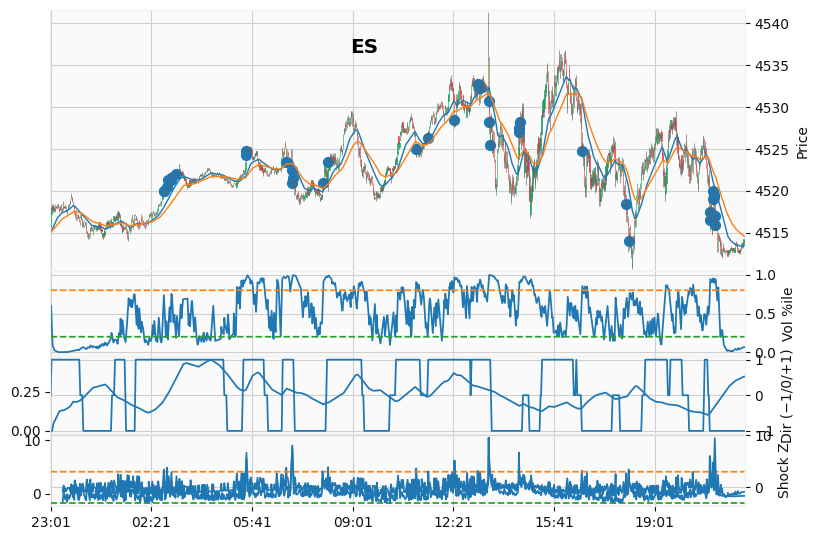

In [16]:
import numpy as np
import pandas as pd
import mplfinance as mpf


def plot_es_regime_candles(
    df: pd.DataFrame,
    session_id=None,                 # int | list[int] | tuple(start,end) | None
    t_start=None,                    # "HH:MM" or "HH:MM:SS" or datetime.time
    t_end=None,                      # "HH:MM" or "HH:MM:SS" or datetime.time
    title="ES Regime Diagnostics (Candles)",
    show_non_rth=True,               # if False and you pass t_start/t_end, outside window removed
    max_bars=None,                   # optional safety cap for huge slices
):
    """
    Candlestick + regime panels, filterable by session_ID and time-of-day.

    Required columns:
      - datetime, open, high, low, close, session_ID

    Optional columns (plotted if present):
      - ema_30m, ema_60m
      - vol_ratio_pct
      - dir_state (down/flat/up)
      - ADX60
      - range_z, volume_z
      - is_shock (bool)
    """

    data = df.copy()

    # ---- ensure datetime ----
    if "datetime" not in data.columns:
        if {"Date", "Time"}.issubset(data.columns):
            data["datetime"] = pd.to_datetime(
                data["Date"].astype(str) + " " + data["Time"].astype(str),
                errors="coerce"
            )
        else:
            raise ValueError("df must have 'datetime' or both 'Date' and 'Time'.")

    data = data.dropna(subset=["datetime"]).sort_values("datetime")

    # ---- filter by session_ID ----
    if session_id is not None:
        if isinstance(session_id, (list, set, tuple, np.ndarray)) and not (
            isinstance(session_id, tuple) and len(session_id) == 2 and all(isinstance(x, (int, np.integer)) for x in session_id)
        ):
            # list-like of IDs (except range tuple handled below)
            data = data[data["session_ID"].isin(list(session_id))]

        elif isinstance(session_id, tuple) and len(session_id) == 2 and all(isinstance(x, (int, np.integer)) for x in session_id):
            # range inclusive: (start_id, end_id)
            s0, s1 = session_id
            data = data[(data["session_ID"] >= s0) & (data["session_ID"] <= s1)]

        else:
            # single int
            data = data[data["session_ID"] == int(session_id)]

    if data.empty:
        raise ValueError("No data left after session_ID filtering.")

    # ---- filter by time-of-day window ----
    def _to_time(x):
        if x is None:
            return None
        if isinstance(x, str):
            return pd.to_datetime(x).time()
        return x  # assume datetime.time

    ts = _to_time(t_start)
    te = _to_time(t_end)

    if ts is not None and te is not None:
        mask = (data["datetime"].dt.time >= ts) & (data["datetime"].dt.time <= te)
        if show_non_rth:
            # Keep full session, but we'll still highlight window by slicing plots? (simpler: filter)
            data = data.loc[mask]
        else:
            data = data.loc[mask]

    if data.empty:
        raise ValueError("No data left after time window filtering.")

    # ---- optional cap ----
    if max_bars is not None and len(data) > int(max_bars):
        data = data.iloc[-int(max_bars):].copy()

    # ---- set datetime index for mplfinance ----
    data = data.set_index("datetime")
    data.index = pd.DatetimeIndex(data.index)

    # Ensure OHLC numeric
    for c in ["open", "high", "low", "close"]:
        data[c] = pd.to_numeric(data[c], errors="coerce")
    data = data.dropna(subset=["open", "high", "low", "close"])
    if data.empty:
        raise ValueError("No valid OHLC rows after numeric coercion.")

    # ---- build addplots ----
    apds = []

    # Price overlays
    if "ema_30m" in data.columns:
        apds.append(mpf.make_addplot(data["ema_30m"], panel=0, width=1))
    if "ema_60m" in data.columns:
        apds.append(mpf.make_addplot(data["ema_60m"], panel=0, width=1))

    # Shock markers on price panel
    if "is_shock" in data.columns:
        shock_mask = data["is_shock"].fillna(False).astype(bool)
        if shock_mask.any():
            shock_prices = data["close"].where(shock_mask)
            apds.append(
                mpf.make_addplot(
                    shock_prices,
                    type="scatter",
                    panel=0,
                    markersize=50,
                )
            )

    # Panel 1: volatility percentile
    if "vol_ratio_pct" in data.columns:
        apds.append(mpf.make_addplot(data["vol_ratio_pct"], panel=1, ylabel="Vol %ile"))
        # reference bands
        apds.append(mpf.make_addplot(pd.Series(0.80, index=data.index), panel=1, linestyle="--"))
        apds.append(mpf.make_addplot(pd.Series(0.20, index=data.index), panel=1, linestyle="--"))

    # Panel 2: direction state + ADX60
    dir_map = {"down": -1, "flat": 0, "up": 1}
    if "dir_state" in data.columns:
        dir_numeric = data["dir_state"].map(dir_map).fillna(0.0)
        apds.append(
            mpf.make_addplot(
                dir_numeric,
                panel=2,
                ylabel="Dir (−1/0/+1)",
                secondary_y=False
            )
        )


    if "ADX60" in data.columns:
        # Scale ADX60 to fit roughly in the same panel (optional; adjust if you prefer a dedicated panel)
        apds.append(mpf.make_addplot((data["ADX60"] / 50.0), panel=2, secondary_y=True))

    # Panel 3: shock diagnostics
    if "range_z" in data.columns:
        apds.append(mpf.make_addplot(data["range_z"], panel=3, ylabel="Shock Z"))
    if "volume_z" in data.columns:
        apds.append(mpf.make_addplot(data["volume_z"], panel=3))

    # Reference lines for shock z (if panel 3 exists)
    if any(col in data.columns for col in ["range_z", "volume_z"]):
        apds.append(mpf.make_addplot(pd.Series(3.0, index=data.index), panel=3, linestyle="--"))
        apds.append(mpf.make_addplot(pd.Series(-3.0, index=data.index), panel=3, linestyle="--"))

    # Decide how many panels are actually used
    # We always have panel 0. Add panel count depending on which series exist.
    panel_used = 1
    if "vol_ratio_pct" in data.columns:
        panel_used = max(panel_used, 2)
    if ("dir_state" in data.columns) or ("ADX60" in data.columns):
        panel_used = max(panel_used, 3)
    if ("range_z" in data.columns) or ("volume_z" in data.columns):
        panel_used = max(panel_used, 4)

    # Panel ratios (price largest)
    if panel_used == 1:
        ratios = (1,)
    elif panel_used == 2:
        ratios = (4, 1.3)
    elif panel_used == 3:
        ratios = (4, 1.3, 1.2)
    else:
        ratios = (4, 1.3, 1.2, 1.1)

    mpf.plot(
        data[["open", "high", "low", "close"]],
        type="candle",
        style="yahoo",
        addplot=apds,
        title=title,
        ylabel="Price",
        volume=False,
        panel_ratios=ratios,
        datetime_format="%H:%M",
        tight_layout=True,
        xrotation=0,
    )


plot_es_regime_candles(
    regime_df,
    session_id=4,
    t_start=None,
    t_end=None,
    title="ES"
)
